# 네이버 영화 리뷰 감성 분석하기

## 1. 데이터 준비하기

네이버 영화 리뷰 데이터 불러오기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Mecab
import  gensim

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성하기

data_to_word , word_to_index

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 sentence 제거
    train_data = train_data.dropna(how = 'any')                   # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = [] #x_train 설정
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 문장 내 형태소 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 temp_x 성분 중 stopwords가 아닌 것만 정리
        X_train.append(temp_X)
        
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist() #np.concatenate : 서로 다른 길이의 문장 합치기. tolist : [[list],[list] ] 형태를 [list]
    print(words[:100])
    counter = Counter(words)
    counter = counter.most_common(num_words-4) #pad, bos, unk, unused 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index , words
    
X_train, y_train, X_test, y_test, word_to_index, words = load_data(train_data, test_data) 

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리', '흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나', '너무', '재', '밓었다그래서보는것을추천한다', '교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정', '사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다', '막', '걸음마', '뗀', '3', '세', '부터', '초등', '학교', '1', '학년', '생', '인', '8', '살', '용', '영화', '.', 'ㅋㅋㅋ', '.', '..', '별반', '개', '아까움', '.', '원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.']


In [3]:
print(X_train[0])
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

#### encoder - decoder 정의

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
get_encoded_sentence('영화 다 고 하 을 보',word_to_index)

[1, 5, 6, 7, 8, 9, 10]

## 2. 모델 구성을 위한 데이터 분석 및 가공

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences_maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='len', ylabel='Density'>

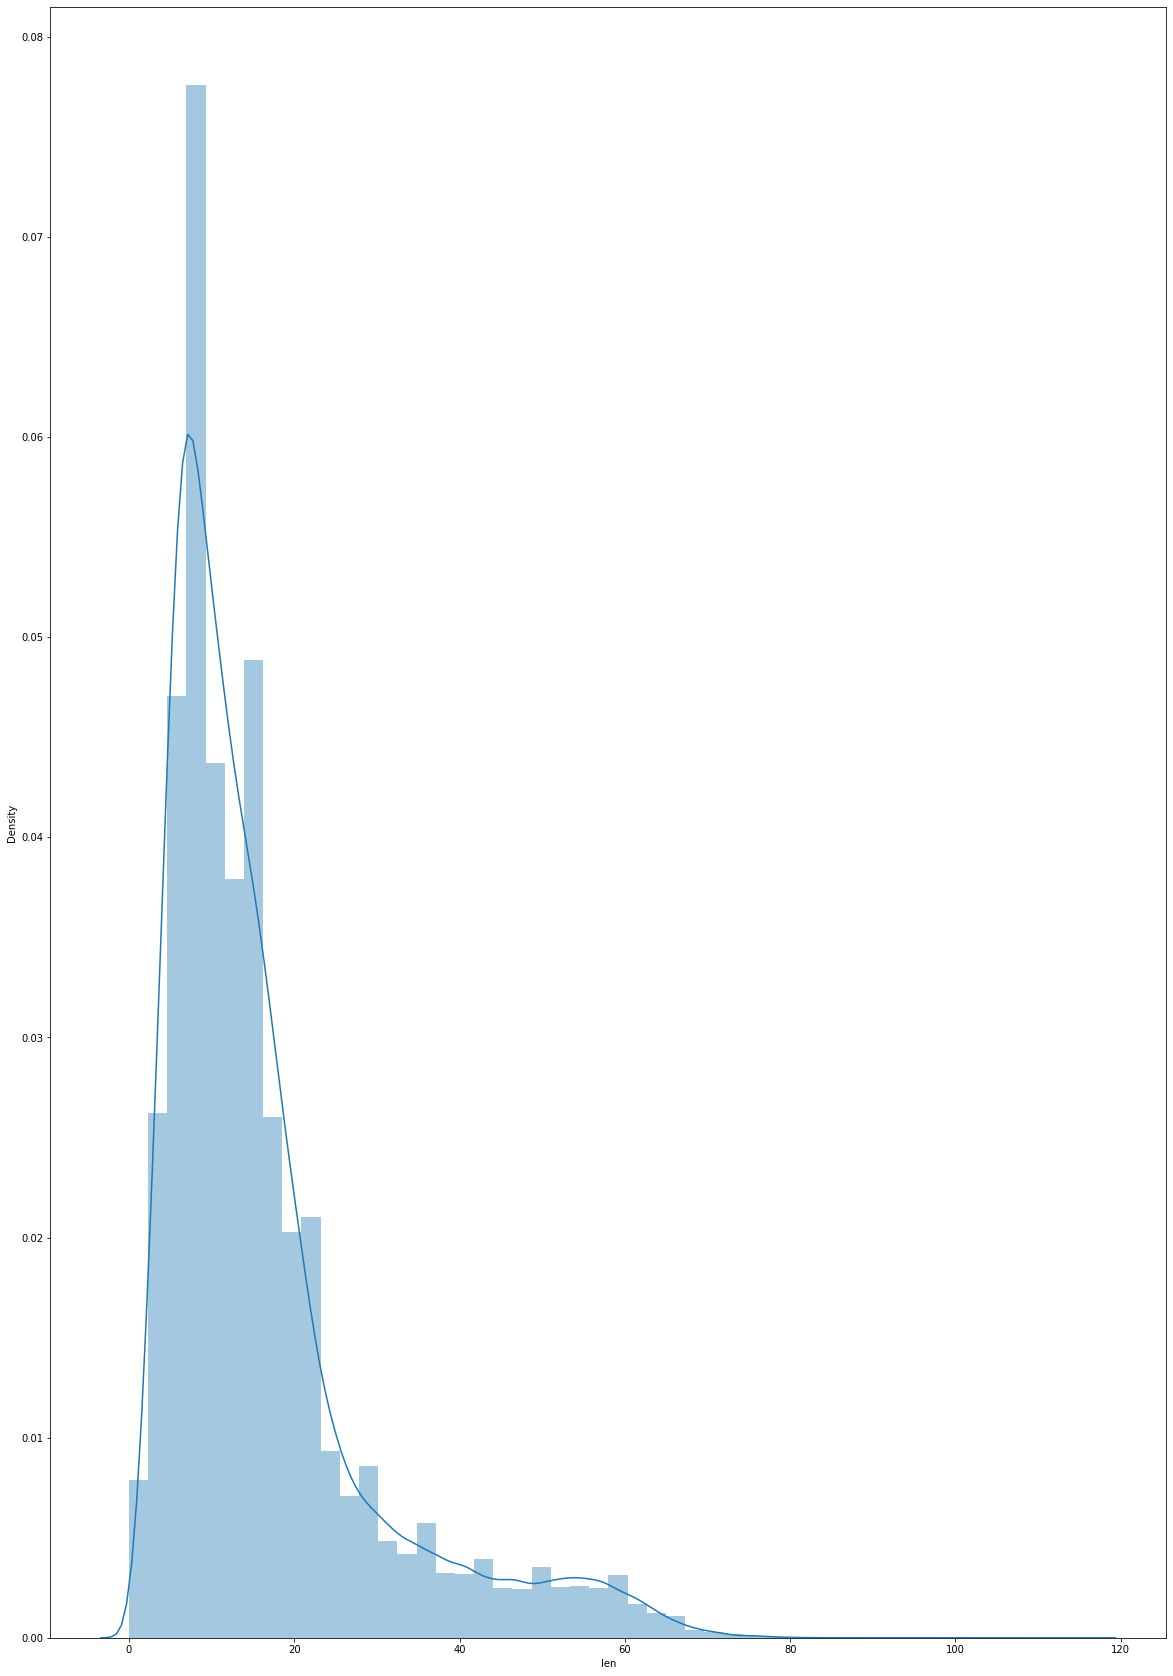

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text] #데이터셋 마다 num_token 구하기!
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences_maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

#시각화
fig, ax = plt.subplots(figsize=(20,30))

num_tokens_pd = pd.DataFrame(num_tokens)
num_tokens_pd.columns = ["len"]

sns.distplot(num_tokens_pd['len'], ax = ax)

## 3. 모델 구성

LSTM model

LSTM 이므로 pre padding 진행

In [7]:
#maxlen = 54
X_train_rnn = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test_rnn = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 ''post
                                                      maxlen=maxlen)
y_train_rnn = y_train.copy()


x_train_rnn , x_valid_rnn , y_train_rnn, y_valid_rnn = train_test_split(X_train_rnn,y_train_rnn,test_size = 0.2, random_state = 42)

print("x_train :",x_train_rnn.shape)
print("x_valid : ",x_valid_rnn.shape)

x_train : (116945, 54)
x_valid :  (29237, 54)


In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model_rnn 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


모델 훈련

In [9]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(x_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid_rnn, y_valid_rnn),
                    verbose=1,callbacks=callback)

Epoch 1/20
229/229 [==============================] - 9s 27ms/step - loss: 0.5611 - accuracy: 0.7586 - val_loss: 0.3617 - val_accuracy: 0.8464
Epoch 2/20
229/229 [==============================] - 5s 23ms/step - loss: 0.3294 - accuracy: 0.8655 - val_loss: 0.3477 - val_accuracy: 0.8484
Epoch 3/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2972 - accuracy: 0.8783 - val_loss: 0.3428 - val_accuracy: 0.8501
Epoch 4/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2811 - accuracy: 0.8845 - val_loss: 0.3493 - val_accuracy: 0.8515
Epoch 5/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2658 - accuracy: 0.8904 - val_loss: 0.3490 - val_accuracy: 0.8507
Epoch 6/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2463 - accuracy: 0.8994 - val_loss: 0.3516 - val_accuracy: 0.8538
Epoch 7/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2292 - accuracy: 0.9072 - val_loss: 0.3689 - val_accuracy: 0.8554

In [10]:
results_rnn = model_rnn.evaluate(X_test_rnn,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 6s - loss: 0.4234 - accuracy: 0.8474
[0.4234188497066498, 0.8474479913711548]


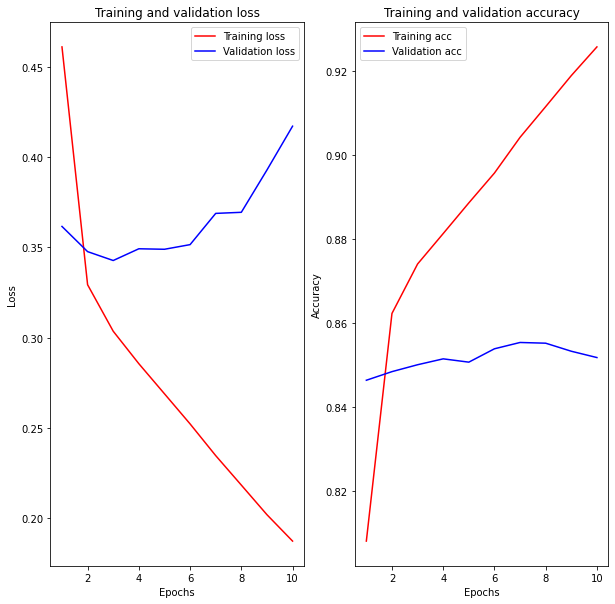

In [11]:
history_rnn_dict = history_rnn.history

acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

gensim 이용 word_to_vec

In [12]:
#vocab size = 10000, word_vector_dim = 100
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [13]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

기준이 뭘까... 

In [14]:
word_vectors.similar_by_word("재미")

[('거의', 0.7676725387573242),
 ('매우', 0.7641090154647827),
 ('긴장감', 0.7619941234588623),
 ('넘', 0.7550836205482483),
 ('한마디', 0.7495607733726501),
 ('너무', 0.7440831661224365),
 ('난', 0.7353911399841309),
 ('이렇게', 0.7327897548675537),
 ('정말', 0.7252612113952637),
 ('몰입', 0.7158450484275818)]

___

1 - D CNN

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(x_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid_rnn, y_valid_rnn),
                    verbose=1,callbacks=callback)

Epoch 1/20
229/229 [==============================] - 11s 36ms/step - loss: 0.6151 - accuracy: 0.6277 - val_loss: 0.4301 - val_accuracy: 0.7919
Epoch 2/20
229/229 [==============================] - 5s 21ms/step - loss: 0.3909 - accuracy: 0.8183 - val_loss: 0.4159 - val_accuracy: 0.7981
Epoch 3/20
229/229 [==============================] - 5s 20ms/step - loss: 0.3377 - accuracy: 0.8471 - val_loss: 0.4261 - val_accuracy: 0.7983
Epoch 4/20
229/229 [==============================] - 4s 19ms/step - loss: 0.2692 - accuracy: 0.8824 - val_loss: 0.4547 - val_accuracy: 0.7940
Epoch 5/20
229/229 [==============================] - 4s 19ms/step - loss: 0.2105 - accuracy: 0.9095 - val_loss: 0.5243 - val_accuracy: 0.7888
Epoch 6/20
229/229 [==============================] - 4s 19ms/step - loss: 0.1638 - accuracy: 0.9282 - val_loss: 0.5944 - val_accuracy: 0.7838


In [17]:
results_cnn = model_cnn.evaluate(X_test_rnn,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 5s - loss: 0.5973 - accuracy: 0.7840
[0.5972736477851868, 0.7839575409889221]


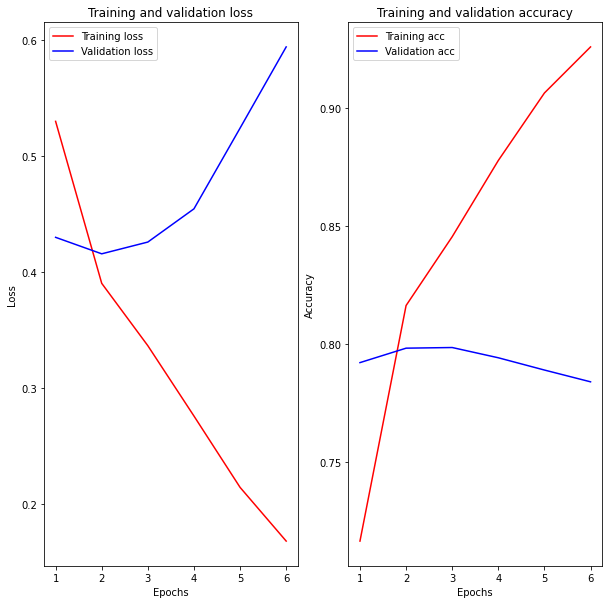

In [18]:
history_cnn_dict = history_cnn.history

acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [19]:
#vocab size = 10000, word_vector_dim = 100
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("재미")

[('야말로', 0.4988921880722046),
 ('우기', 0.473939448595047),
 ('마법', 0.4632434546947479),
 ('못생긴', 0.461357980966568),
 ('막', 0.4610389173030853),
 ('또라이', 0.4603385627269745),
 ('했으나', 0.45340120792388916),
 ('몰라요', 0.4502134621143341),
 ('남북', 0.448657751083374),
 ('싸워', 0.4394008219242096)]

GRU

In [21]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(vocab_size, 100))
model_gru.add(keras.layers.GRU(128))
model_gru.add(keras.layers.Dense(1, activation='sigmoid'))

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [22]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gru = model_cnn.fit(x_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid_rnn, y_valid_rnn),
                    verbose=1,callbacks=callback)

Epoch 1/20
229/229 [==============================] - 4s 19ms/step - loss: 0.1364 - accuracy: 0.9385 - val_loss: 0.6746 - val_accuracy: 0.7802
Epoch 2/20
229/229 [==============================] - 4s 19ms/step - loss: 0.1158 - accuracy: 0.9457 - val_loss: 0.7632 - val_accuracy: 0.7802
Epoch 3/20
229/229 [==============================] - 4s 19ms/step - loss: 0.1022 - accuracy: 0.9513 - val_loss: 0.8562 - val_accuracy: 0.7797
Epoch 4/20
229/229 [==============================] - 4s 19ms/step - loss: 0.0938 - accuracy: 0.9547 - val_loss: 0.9239 - val_accuracy: 0.7784
Epoch 5/20
229/229 [==============================] - 4s 19ms/step - loss: 0.0872 - accuracy: 0.9567 - val_loss: 1.0505 - val_accuracy: 0.7735


In [23]:
results_gru = model_gru.evaluate(X_test_rnn,  y_test, verbose=2)

print(results_gru)

1537/1537 - 7s - loss: 0.6938 - accuracy: 0.4734
[0.6937904953956604, 0.4734219014644623]


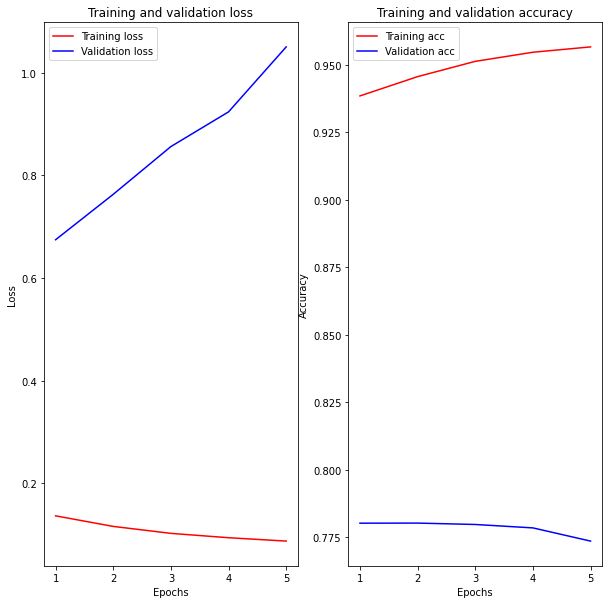

In [24]:
history_gru_dict = history_gru.history

acc = history_gru_dict['accuracy']
val_acc = history_gru_dict['val_accuracy']
loss = history_gru_dict['loss']
val_loss = history_gru_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [25]:
#vocab size = 10000, word_vector_dim = 100
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gru.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gru.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

결과가 충격적이다.

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("재미")

[('복습', 0.43902328610420227),
 ('설레', 0.41624364256858826),
 ('한심', 0.36323878169059753),
 ('무모', 0.3550788164138794),
 ('천재', 0.34821033477783203),
 ('도배', 0.3402595520019531),
 ('범인', 0.3361009359359741),
 ('떨어져서', 0.3185499310493469),
 ('_', 0.31172335147857666),
 ('스타뎀', 0.3115297555923462)]

## 4. 결과 

사전 훈련된 word2vec을 사용하지 않았을 때 LSTM 모델이 0.8474로 가장 높은 정확도를 기록했다.

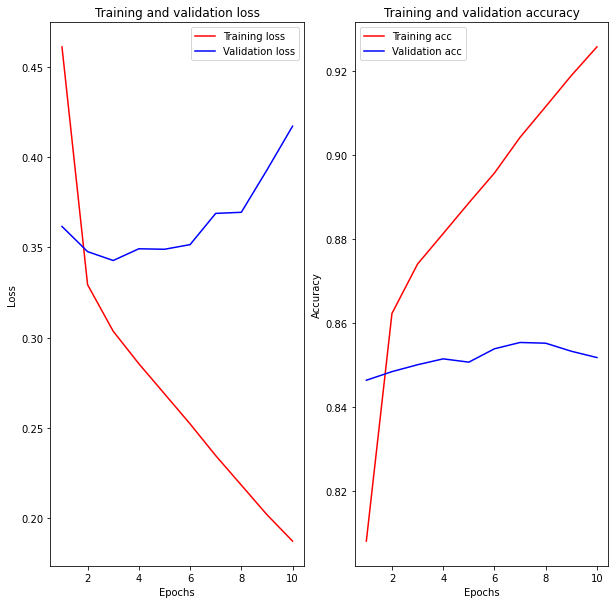

## 5. 한국어 word2vec을 이용한 성능 개선

LSTM 모델은 word2vec을 사용하기 전에도 0.8474의 정확도를 기록했으므로 0.85를 넘기 위해 word2vec을 이용해보려고 한다!

In [27]:
!pip install gensim==3.8.1

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


1D -CNN

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_word = keras.Sequential()
model_word.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_word.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_word.add(keras.layers.MaxPooling1D(5))
model_word.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_word.add(keras.layers.GlobalMaxPooling1D())
model_word.add(keras.layers.Dense(8, activation='relu'))
model_word.add(keras.layers.Dense(1, activation='sigmoid')) 

model_word.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

model_word.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_word = model_word.fit(x_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid_rnn, y_valid_rnn),
                    verbose=1,callbacks=callback)

In [ ]:
results_word = model_word.evaluate(X_test_rnn,  y_test, verbose=2)

print(results_word)

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
history_word_dict = history_word.history_word

acc = history_word_dict['accuracy']
val_acc = history_word_dict['val_accuracy']
loss = history_word_dict['loss']
val_loss = history_word_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [72]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix), 
                                      input_shape=(None,),
                                      trainable=True))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [79]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train_rnn,
                    y_train_rnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid_rnn, y_valid_rnn),
                    verbose=1,callbacks=callback)

Epoch 1/20
229/229 [==============================] - 10s 37ms/step - loss: 0.2252 - accuracy: 0.9123 - val_loss: 0.3694 - val_accuracy: 0.8518
Epoch 2/20
229/229 [==============================] - 7s 32ms/step - loss: 0.2152 - accuracy: 0.9165 - val_loss: 0.3748 - val_accuracy: 0.8522
Epoch 3/20
229/229 [==============================] - 7s 31ms/step - loss: 0.2038 - accuracy: 0.9224 - val_loss: 0.3863 - val_accuracy: 0.8502


In [80]:
results = model.evaluate(X_test_rnn,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3962 - accuracy: 0.8453
[0.39623144268989563, 0.8453119397163391]


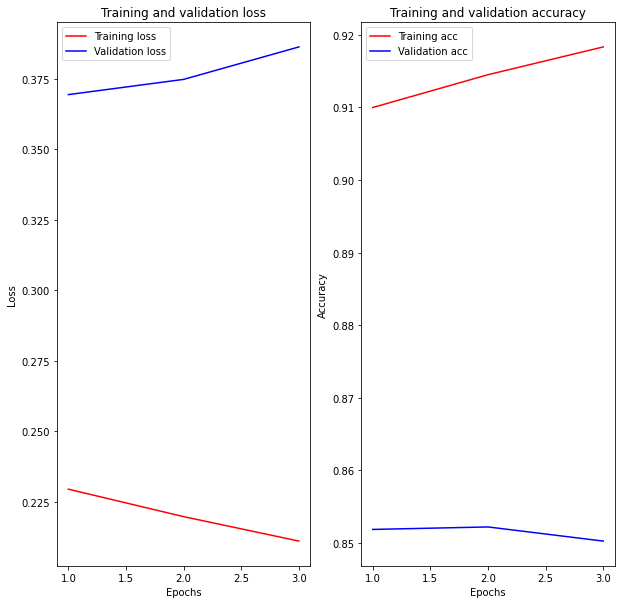

In [81]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

## 6. 문장 입력 받아 예측하기

마지막 accuracy 처리 단계에서 시간이 부족했다.

리뷰 예측해보기

In [29]:
'''
def get_encoded_sentence_new(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]
'''

"\ndef get_encoded_sentence_new(sentence, word_to_index):\n    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]\n"

In [30]:
'''
def sentiment_predict(new_sentence,word_to_index):
    
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    print(new_sentence)
    encoded = get_encoded_sentence_new(new_sentence,word_to_index)
    pad_size = maxlen-len(encoded)
    pad_new = np.pad(encoded,(maxlen-len(encoded),0),'constant',constant_values=word_to_index['<BOS>'])[:maxlen]
    print(pad_new)
    score = model_rnn.predict(pad_new) # 예측
    print(score[pad_size:])
    score = np.mean(score[pad_size:]) #요걸 고쳐야됨
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
'''

'\ndef sentiment_predict(new_sentence,word_to_index):\n    \n    new_sentence = tokenizer.morphs(new_sentence) # 토큰화\n    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거\n    print(new_sentence)\n    encoded = get_encoded_sentence_new(new_sentence,word_to_index)\n    pad_size = maxlen-len(encoded)\n    pad_new = np.pad(encoded,(maxlen-len(encoded),0),\'constant\',constant_values=word_to_index[\'<BOS>\'])[:maxlen]\n    print(pad_new)\n    score = model_rnn.predict(pad_new) # 예측\n    print(score[pad_size:])\n    score = np.mean(score[pad_size:]) #요걸 고쳐야됨\n    if(score > 0.5):\n        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))\n    else:\n        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))\n'

In [31]:
#sentiment_predict('기대이상이었음 코로나시국에 개봉해 내가 다 아쉬울지경 연기 연출 모두 빠질 것 없이 훌륭하다 생각합니다 추천해요!!!',word_to_index)

In [32]:
'''
def sentiment_predict(new_sentence,tokenizer_pre):
    
    new_sentence = Okt.morphs(new_sentence,stem = True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

tokenizer_pre = Tokenizer(vocab_size) 
tokenizer_pre.fit_on_texts(words)
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ',tokenizer_pre)
'''

'\ndef sentiment_predict(new_sentence,tokenizer_pre):\n    \n    new_sentence = Okt.morphs(new_sentence,stem = True) # 토큰화\n    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거\n    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩\n    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩\n    score = float(loaded_model.predict(pad_new)) # 예측\n    \n    if(score > 0.5):\n        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))\n    else:\n        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))\n\ntokenizer_pre = Tokenizer(vocab_size) \ntokenizer_pre.fit_on_texts(words)\nsentiment_predict(\'이 영화 개꿀잼 ㅋㅋㅋ\',tokenizer_pre)\n'

# 정리

- 미리 라벨링된 영화 감상 데이터를 이용해서 영화에 대한 감상이 긍정적인지 부정적인지를 구분할 수 있었다.

다양한 모델을 통해서 데이터를 훈련시켜 classifier를 구성해봤는데 LSTM 모델이 가장 우수한 성능을 보였다. 후에 더 나은 성능 개선을 위해서 
사전 학습된 word2vec embedding data를 학습에 활용했지만 생각보다 성능이 많이 개선되지는 않았다.

또한 학습된 모델을 통해 최종적으로 임의의 문장을 입력 받아서 그 문장이 긍정인지 부정인지를 확인해주는 판별기를 만들고 싶었지만 시간이 부족해서 구현엔 실패했다.

저번 주 해커톤 진행 이후 밀린 노드들을 처리하느라 더 세세한 작업은 못해본 것이 아쉽다.